## Homework#1
### - 수업시간에 배운 내용과 실습한 코드들을 이용해서 아래 내용에 대한 코드를 작성하고, 코드와 결과를 넣은 보고서를 제출하시오.

### 0. MNIST 데이터를 읽고, 70%는 학습데이터, 30%는 데스트데이터로 구분(dataloader)하시오.

In [162]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

# 데이터셋 사이즈
total_size = len(mnist_dataset)
train_size = int(0.7 * total_size)
test_size = total_size - train_size

# 학습/테스트 데이터셋 분할
train_dataset, test_dataset = random_split(mnist_dataset, [train_size, test_size])


batch_size = 64

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 데이터셋 사이즈 출력
print(len(train_loader))
print(len(test_loader))

657
282


### 1. Hidden layer가 2개이고, 각 node는 20개인 MLP 모델(model)을 구현하시오.


In [163]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self, activation=nn.ReLU()):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 10)

        self.activation = activation

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)

        return x

model = MLP(nn.Sigmoid()).to(device)

In [164]:
# MLP 모델 정의(배치 정규화 추가)
class MLP(nn.Module):
    def __init__(self, activation=nn.ReLU()):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 20)
        self.bn1 = nn.BatchNorm1d(20)
        self.fc2 = nn.Linear(20, 20)
        self.bn2 = nn.BatchNorm1d(20)
        self.fc3 = nn.Linear(20, 10)

        self.activation = activation

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)

        return x

model = MLP(nn.Sigmoid()).to(device)

In [165]:
# 3. 손실 함수 & 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

Epoch [1/10] - Loss: 1.6453, Train Acc: 60.55%, Test Acc: 81.86%
Epoch [2/10] - Loss: 0.6731, Train Acc: 87.23%, Test Acc: 88.79%
Epoch [3/10] - Loss: 0.4204, Train Acc: 89.97%, Test Acc: 90.07%
Epoch [4/10] - Loss: 0.3365, Train Acc: 91.33%, Test Acc: 91.04%
Epoch [5/10] - Loss: 0.2909, Train Acc: 92.28%, Test Acc: 91.88%
Epoch [6/10] - Loss: 0.2609, Train Acc: 92.99%, Test Acc: 92.33%
Epoch [7/10] - Loss: 0.2366, Train Acc: 93.45%, Test Acc: 92.77%
Epoch [8/10] - Loss: 0.2176, Train Acc: 93.92%, Test Acc: 93.12%
Epoch [9/10] - Loss: 0.2027, Train Acc: 94.33%, Test Acc: 93.41%
Epoch [10/10] - Loss: 0.1894, Train Acc: 94.68%, Test Acc: 93.71%


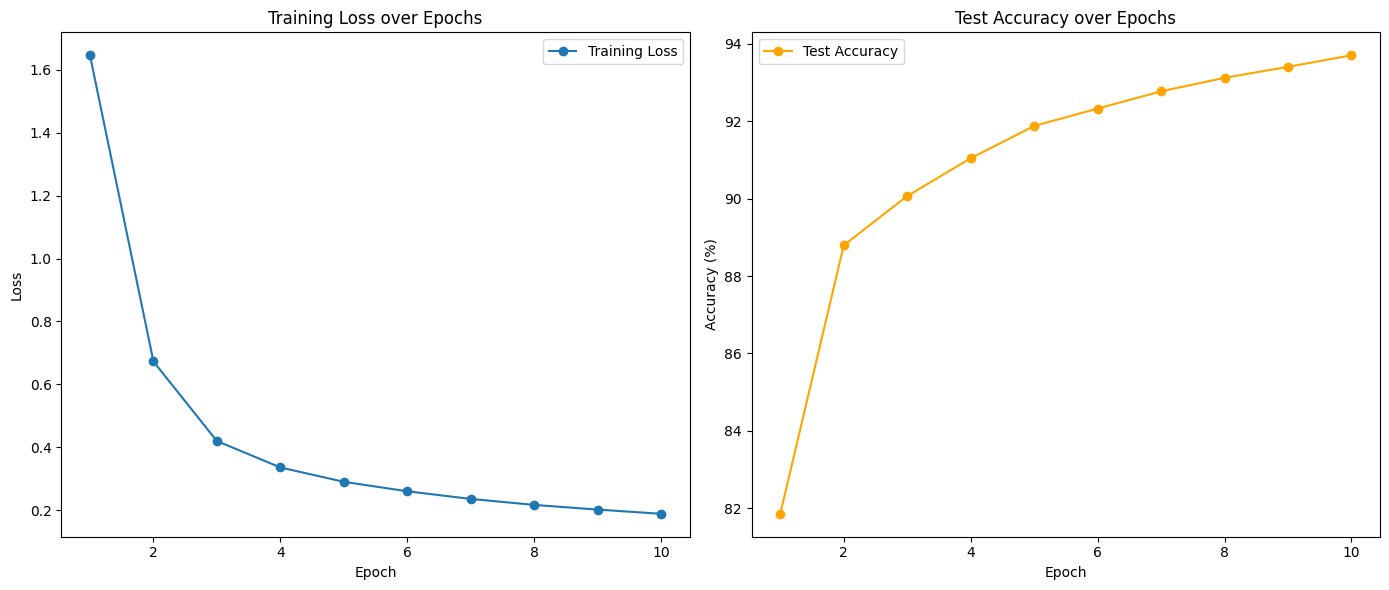

In [166]:
import matplotlib.pyplot as plt

# Lists to store metrics
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on test set
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    test_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {val_accuracy:.2f}%")

# Plotting metrics
plt.figure(figsize=(14, 6))

# Training loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", marker="o")
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Test accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), test_accuracies, label="Test Accuracy", marker="o", color="orange")
plt.title("Test Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()


### 4. 카이밍 초기화, 제이비어 초기화, 정규분포 초기화를 적용했을 때의 결과를 출력하시오.

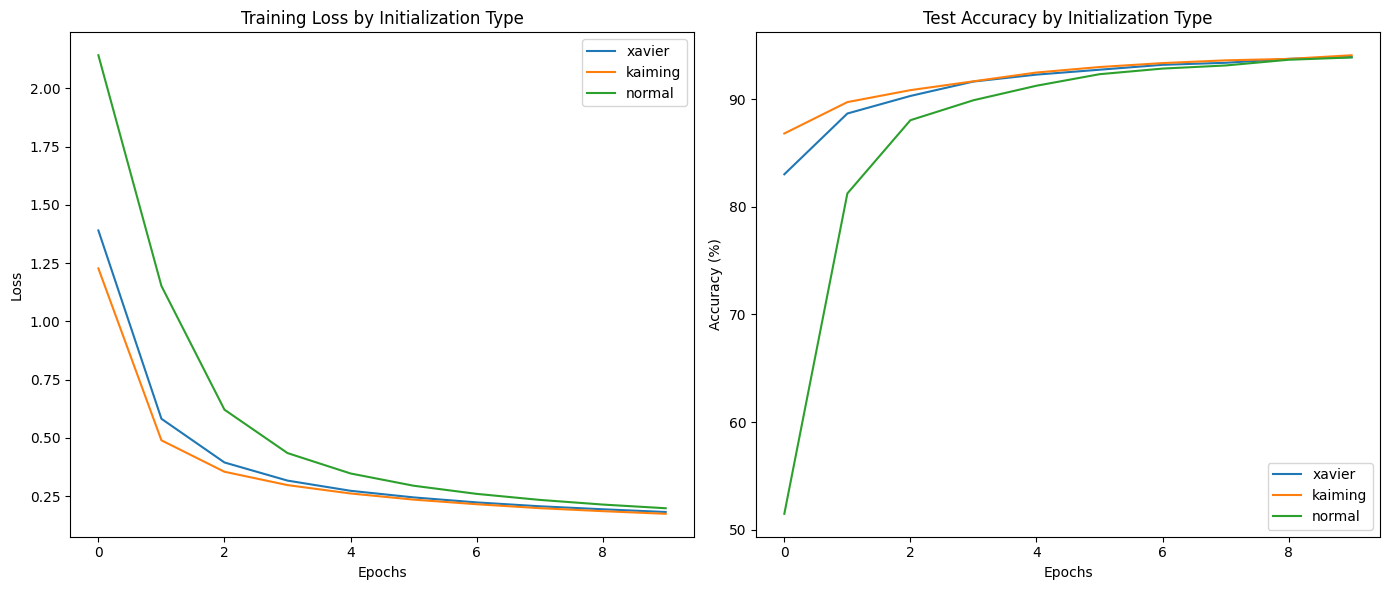

In [167]:
import matplotlib.pyplot as plt

# Function to initialize model weights
def initialize_weights(model, init_type):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            if init_type == "xavier":
                nn.init.xavier_uniform_(layer.weight)
            elif init_type == "kaiming":
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
            elif init_type == "normal":
                nn.init.normal_(layer.weight, mean=0.0, std=0.1)

# Function to train model and collect results
def train_and_collect_results(init_type):
    results[init_type] = {"loss": [], "accuracy": []}
    initialize_weights(model, init_type)

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        results[init_type]["loss"].append(avg_loss)
        results[init_type]["accuracy"].append(val_accuracy)

# Initialize results dictionary
results = {}

# Train model with different initializations
train_and_collect_results("xavier")
train_and_collect_results("kaiming")
train_and_collect_results("normal")

# Plot results
plt.figure(figsize=(14, 6))

# Training Loss Plot
plt.subplot(1, 2, 1)
for init_type in results:
    plt.plot(results[init_type]["loss"], label=init_type)
plt.title("Training Loss by Initialization Type")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Test Accuracy Plot
plt.subplot(1, 2, 2)
for init_type in results:
    plt.plot(results[init_type]["accuracy"], label=init_type)
plt.title("Test Accuracy by Initialization Type")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()
